In [1]:
import sqlite3
import pandas as pd
from datetime import datetime

In [2]:
# Conectar a la base de datos SQLite
conn = sqlite3.connect('sanoyfresco.db')

In [6]:
# Cargamos datos relevantes
query = """
SELECT id_cliente, fecha, id_pedido, precio_total
FROM [tickets]
"""
df_tickets = pd.read_sql_query(query, conn)

In [7]:
# Verificamos las primeras filas
df_tickets.head()

,id_cliente,fecha,id_pedido,precio_total
0,112108,2023-02-02 00:00:00,1,3.96
1,112108,2023-02-02 00:00:00,1,9.80
2,112108,2023-02-02 00:00:00,1,3.58
3,202279,2023-02-03 00:00:00,2,5.10
4,202279,2023-02-03 00:00:00,2,4.75


In [11]:
df_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4975718 entries, 0 to 4975717
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id_cliente    int64         
 1   fecha         datetime64[ns]
 2   id_pedido     int64         
 3   precio_total  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 151.8 MB


In [10]:
df_tickets['fecha'] = pd.to_datetime(df_tickets['fecha'])

In [12]:
# Definimos fecha de referencia
fecha_ref = df_tickets['fecha'].max() + pd.Timedelta(days=1)

In [13]:
# Calculamos con lo anterior el RFM agrupando por cliente
df_rfm = df_tickets.groupby('id_cliente').agg({
    'fecha': lambda x: (fecha_ref - x.max()).days,
    'id_pedido': 'nunique',
    'precio_total': 'sum'
}).reset_index()

df_rfm.columns = ['id_cliente', 'Recency', 'Frequency', 'Monetary']

In [14]:
# Clasificación en terciles
df_rfm['R'] = pd.qcut(df_rfm['Recency'], 3, labels=[3, 2, 1])
df_rfm['F'] = pd.qcut(df_rfm['Frequency'], 3, labels=[1, 2, 3])
df_rfm['M'] = pd.qcut(df_rfm['Monetary'], 3, labels=[1, 2, 3])

# Score combinado
df_rfm['RFM_Score'] = df_rfm['R'].astype(str) + df_rfm['F'].astype(str) + df_rfm['M'].astype(str)

df_rfm.head()


,id_cliente,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,1,173,5,43.25,2,2,1,221
1,2,135,15,257.63,3,3,3,333
2,3,231,11,182.70,2,3,3,233
3,4,319,1,15.20,1,1,1,111
4,5,316,5,64.30,1,2,2,122


<ipython-input-16-0b289ad25493>:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_rfm.pivot_table(


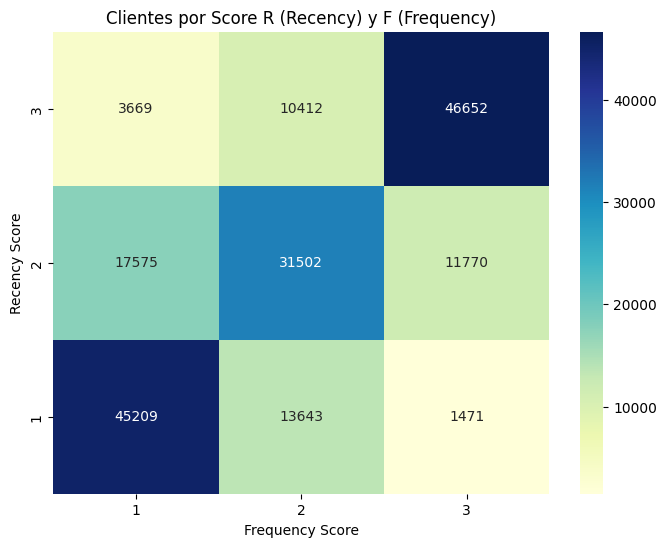

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tabla cruzada
heatmap_data = df_rfm.pivot_table(
    index='R', columns='F', values='id_cliente', aggfunc='count'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Clientes por Score R (Recency) y F (Frequency)')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()


<ipython-input-17-d683408f6464>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_monetary = df_rfm.pivot_table(


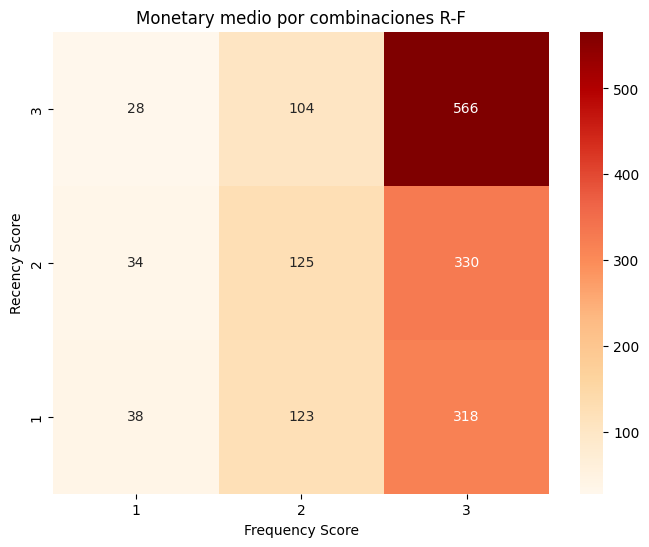

In [17]:
heatmap_monetary = df_rfm.pivot_table(
    index='R', columns='F', values='Monetary', aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_monetary, annot=True, fmt='.0f', cmap='OrRd')
plt.title('Monetary medio por combinaciones R-F')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()


**Supervivencia de clientes**

In [21]:
df = df_tickets.copy()

# Comprobamos tipo de dato de fecha
df['fecha'] = pd.to_datetime(df['fecha'])

# Extraemos el mes y año de la compra
df['MesCompra'] = df['fecha'].dt.to_period('M')

# Obtenemos el primer mes de compra de cada cliente
df['Cohorte'] = df.groupby('id_cliente')['fecha'].transform('min').dt.to_period('M')


In [22]:
# Convertir periodos a enteros para calcular diferencia
df['CohorteIndex'] = (df['MesCompra'].dt.year - df['Cohorte'].dt.year) * 12 + (df['MesCompra'].dt.month - df['Cohorte'].dt.month) + 1


In [23]:
# Contar clientes únicos por cohorte y período
cohort_data = df.groupby(['Cohorte', 'CohorteIndex'])['id_cliente'].nunique().reset_index()

# Pivotar la tabla para obtener matriz de cohortes
cohort_counts = cohort_data.pivot(index='Cohorte', columns='CohorteIndex', values='id_cliente')

# Calcular la retención dividiendo por el número inicial de clientes por cohorte
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)


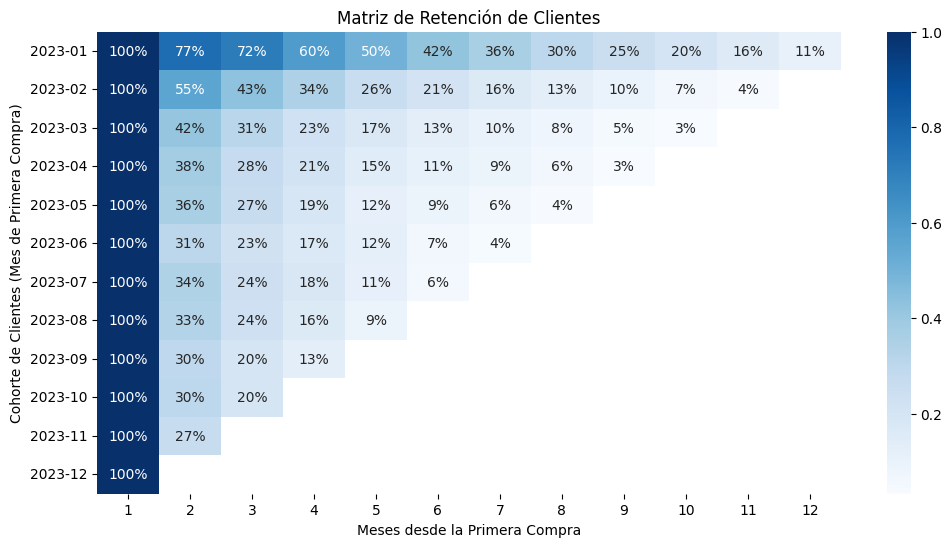

In [24]:
#Visualizamos una matriz de retención de clientes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues")
plt.title('Matriz de Retención de Clientes')
plt.ylabel('Cohorte de Clientes (Mes de Primera Compra)')
plt.xlabel('Meses desde la Primera Compra')
plt.yticks(rotation=0)
plt.show()


**LTV para cada cliente**

In [15]:
#Calculamos el Life Time Value para cada cliente:
df_ltv = df_tickets.groupby('id_cliente').agg({
    'precio_total': 'sum',
    'id_pedido': 'nunique'
}).reset_index()

df_ltv['LTV'] = df_ltv['precio_total'] / df_ltv['id_pedido']
df_ltv.head()


,id_cliente,precio_total,id_pedido,LTV
0,1,43.25,5,8.650000
1,2,257.63,15,17.175333
2,3,182.70,11,16.609091
3,4,15.20,1,15.200000
4,5,64.30,5,12.860000


**Cálculo de la duración del cliente (tiempo de vida) usando Kaplan-Meier**

In [30]:
from datetime import timedelta


In [25]:
# Última fecha en los datos
fecha_corte = df['fecha'].max()

In [27]:
# Agrupar por cliente
clientes = df.groupby('id_cliente').agg(
    primera_compra=('fecha', 'min'),
    ultima_compra=('fecha', 'max')
).reset_index()

In [28]:
# Duración en días entre primera y última compra
clientes['duracion'] = (clientes['ultima_compra'] - clientes['primera_compra']).dt.days

In [31]:
# Creamos variable evento: 1 si abandonó (no volvió después de un periodo), 0 si sigue activo
# Por simplicidad: abandono si no compra en los últimos 90 días
clientes['abandono'] = clientes['ultima_compra'] < (fecha_corte - timedelta(days=90))
clientes['evento'] = clientes['abandono'].astype(int)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.3 MB/s eta 0:00:00


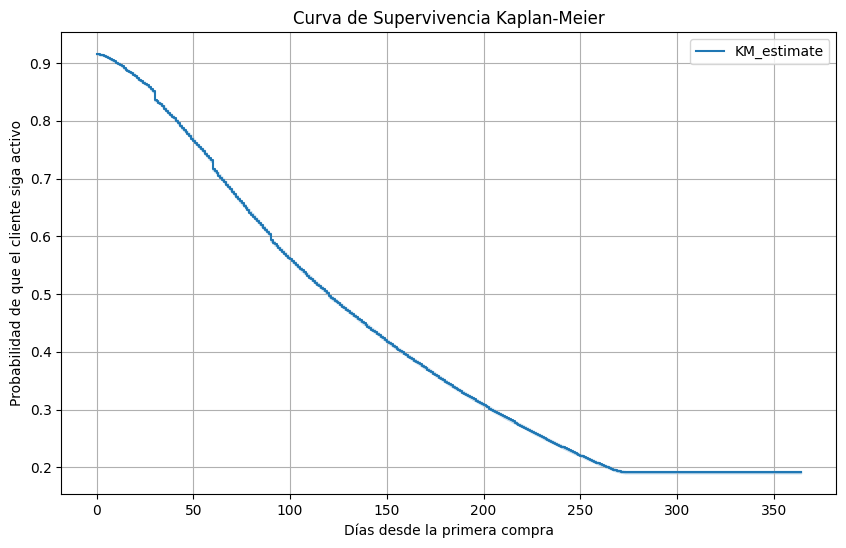

In [32]:
!pip install lifelines --quiet
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Instanciar modelo
kmf = KaplanMeierFitter()

# Ajustar el modelo
kmf.fit(durations=clientes['duracion'], event_observed=clientes['evento'])

# Graficar
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Curva de Supervivencia Kaplan-Meier')
plt.xlabel('Días desde la primera compra')
plt.ylabel('Probabilidad de que el cliente siga activo')
plt.grid(True)
plt.show()
